In [1]:
############
# Imports #
############

import json
import os

import torch
import wandb
from torch.utils.data import DataLoader

from model.cnn_classifier import model_4D
from model.finetune import FinetuneLoop
from model.pseudomask import Pseudomasks
from model.train import ClassifierTrainLoop
from utils.data_modules import ImageDataset, TestSet, filter_dataset

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Hardcode configs: 

artifact_path = 'nadjaflechner/VGG_CAMs/classification_model:v62'

testset_dir = '/Users/nadja/Documents/UU/Thesis/Data/FINALFINAL_200m_groundtruths'
depth_layer = 'hs'
normalize = True
finetune = False

cam_threshold_factor = 0.95
overlap_threshold = 0.3
snic_seeds = 100
snic_compactness = 10
std_from_mean = 2

##################
# evaluate model #
##################

print('Testing model ...')
test_set = TestSet(depth_layer, testset_dir, normalize)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)


Testing model ...


In [3]:
pseudomask_generator = Pseudomasks(test_loader, cam_threshold_factor, overlap_threshold,
                                    snic_seeds, snic_compactness, finetune, std_from_mean)
pseudomask_generator.model_from_artifact(artifact_path)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


### Determining a good activation threshold

In [6]:
bin_labels = []
perc_labels = []
pals_max = []
pals_mean = []

for im, lab, perc_label, gt_mask in test_loader:
    pseudomask, pals_activations = pseudomask_generator.generate_mask(im, gt_mask, save_plot=False)
    bin_labels.append(lab)
    perc_labels.append(perc_label)
    pals_max.append(pals_activations[0])
    pals_mean.append(pals_activations[1])

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


has max activation 0.8119144439697266 and mean 0.7206965684890747
has max activation 0.7699277400970459 and mean 0.7209181785583496
has max activation 2.9484407901763916 and mean 0.5995974540710449
has max activation 1.317726492881775 and mean 0.6815623044967651
has max activation 0.9298104643821716 and mean 0.6624372005462646
has max activation 2.1176085472106934 and mean 0.6695442199707031
has max activation 1.9535866975784302 and mean 0.8568158149719238
has max activation 1.4242292642593384 and mean 0.6994070410728455
has max activation 1.0879745483398438 and mean 0.6605876684188843
has max activation 0.9719039797782898 and mean 0.7267999053001404
has max activation 0.8799968361854553 and mean 0.6895533204078674
has max activation 5.698638439178467 and mean 0.997053325176239
has max activation 3.1334941387176514 and mean 0.802544116973877
has max activation 4.230123043060303 and mean 1.0473413467407227
has max activation 6.34814453125 and mean 0.7752677202224731
has max activation 1

In [7]:
import pandas as pd
activations_dict = {
    'bin_labels' : bin_labels, 
    'perc_labels' : perc_labels, 
    'pals_max' : pals_max, 
    'pals_mean' : pals_mean
}

activations_df = pd.DataFrame(activations_dict)
activations_df.to_csv("testset_activations_analysis")

In [10]:
no_pals_mean_max = activations_df['pals_max'][activations_df['bin_labels'] == 0].mean()
no_pals_mean_mean = activations_df['pals_mean'][activations_df['bin_labels'] == 0].mean()
pals_mean_max = activations_df['pals_max'][activations_df['bin_labels'] == 1].mean()
pals_mean_mean = activations_df['pals_mean'][activations_df['bin_labels'] == 1].mean()

In [11]:
print(no_pals_mean_max)
print(no_pals_mean_mean)
print(pals_mean_max)
print(pals_mean_mean)

1.5470951577159215
0.7005830137408595
4.062686760268526
0.9244877249894742


For images without palsa:
- average max = 1.55
- average mean = 0.70

For images with palsa:
- average max = 4.06
- average mean = 0.92

### Do testing to see which images get the completely wrong accuracy.

In [4]:
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import Accuracy

# define metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
jaccard = MulticlassJaccardIndex(num_classes=2).to(device)
accuracy = Accuracy(task="multiclass", num_classes=2).to(device)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


maximum activation = 4.374658107757568


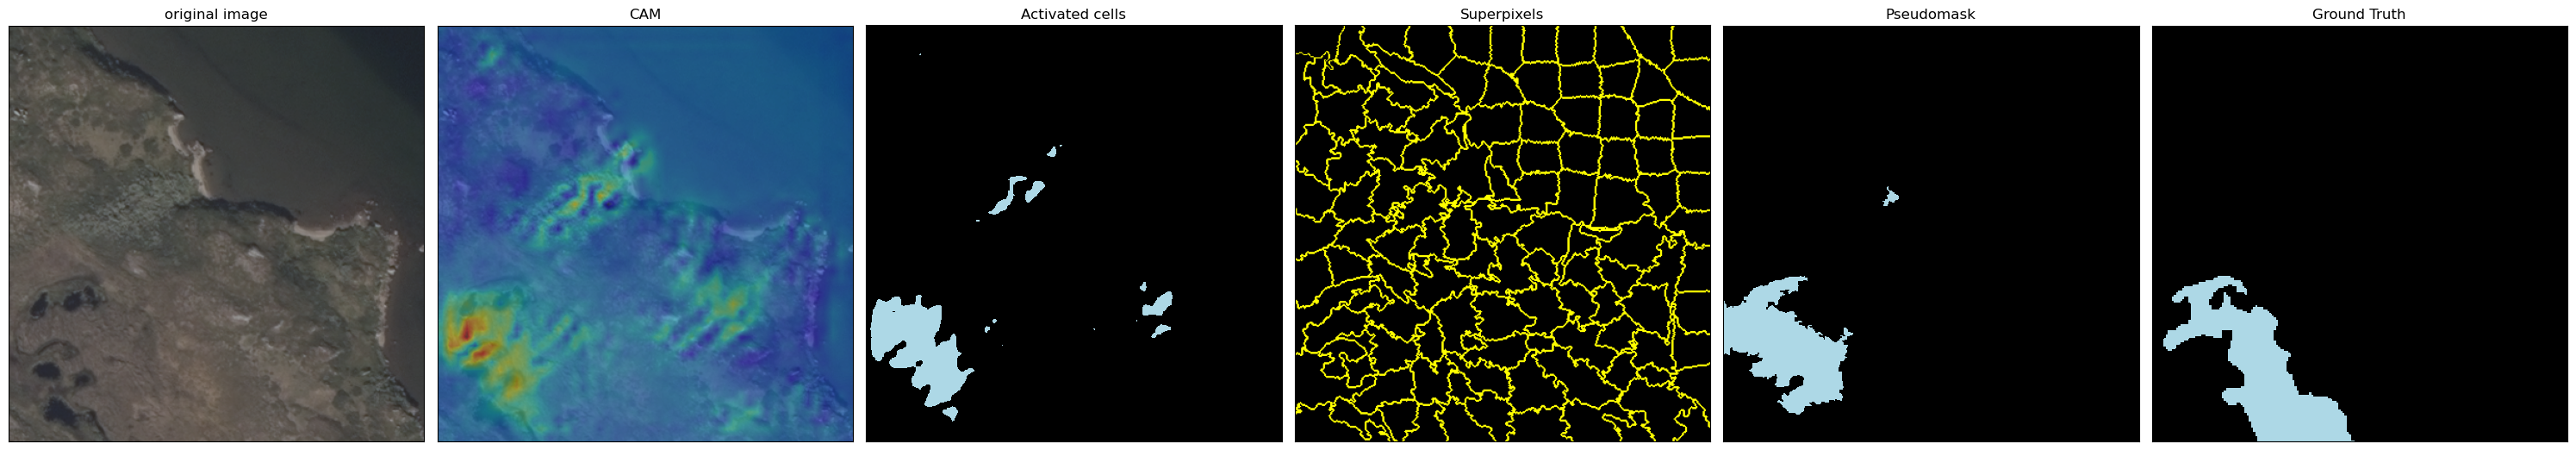

binary label = tensor([1])
perc label = tensor([0.0675], dtype=torch.float64)
accuracy = 0.936662495136261
jaccard = 0.6213538646697998


In [23]:
im, lab, perc_label, gt_mask = next(iter(test_loader))
if lab != 0: 
    pseudomask = pseudomask_generator.generate_mask(im, gt_mask, save_plot=True)
    generated_mask = torch.Tensor(pseudomask).int().view(400,400).to(device)
    groundtruth_mask = torch.Tensor(gt_mask).int().view(400,400).to(device)

    print(f"binary label = {lab}")
    print(f"perc label = {perc_label}")
    print(f"accuracy = {accuracy(generated_mask, groundtruth_mask)}")
    print(f"jaccard = {jaccard(generated_mask, groundtruth_mask)}")


In [24]:
# Evaluate model with new settings 

running_jaccard = []
running_accuracy = []
labels = []

jaccard = MulticlassJaccardIndex(num_classes=2).to(device)
accuracy = Accuracy(task="multiclass", num_classes=2).to(device)

counter = 1
for im, lab, _, gt_mask in test_loader:
    print(counter)
    counter+=1
    pseudomask = pseudomask_generator.generate_mask(im, gt_mask, save_plot=False) # TODO make saveplot true sometimes
    # calculate metrics to evaluate model on test set
    generated_mask = torch.Tensor(pseudomask).int().view(400,400).to(device)
    groundtruth_mask = torch.Tensor(gt_mask).int().view(400,400).to(device)
    
    labels.append(lab)
    running_jaccard.append(jaccard(generated_mask, groundtruth_mask))
    running_accuracy.append(accuracy(generated_mask, groundtruth_mask))

print(f"test_mean_jaccard {sum(running_jaccard) / len(test_loader.dataset)}")
print(f"test_mean_accuracy {sum(running_accuracy) / len(test_loader.dataset)}")


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


1
maximum activation = 3.0226011276245117
2
maximum activation = 7.557138919830322
3
maximum activation = 2.9493069648742676
4
maximum activation = 1.040324091911316
5
maximum activation = 1.100163459777832
6
maximum activation = 0.8835992217063904
7
maximum activation = 2.008744716644287
8
maximum activation = 1.245144248008728
9
maximum activation = 0.8323431611061096
10
maximum activation = 0.7603274583816528
11
maximum activation = 1.3054649829864502
12
maximum activation = 1.9788191318511963
13
maximum activation = 3.4996330738067627
14
maximum activation = 1.5240144729614258
15
maximum activation = 0.9191012978553772
16
maximum activation = 3.903118848800659
17
maximum activation = 1.989254355430603
18
maximum activation = 0.9298104643821716
19
maximum activation = 4.3833513259887695
20
maximum activation = 1.2254817485809326
21
maximum activation = 0.8988085985183716
22
maximum activation = 1.7591623067855835
23
maximum activation = 0.7803623080253601
24
maximum activation = 2.2

In [26]:
import pandas as pd
test_res = pd.DataFrame({
    "running_jaccard": running_jaccard,
    "running_accuracy": running_accuracy,
    "labels": labels
    })

In [30]:
test_res[test_res['labels'] == 0]["running_jaccard"].mean()

0.7731173685844371

In [14]:
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import Accuracy

# define metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
jaccard = MulticlassJaccardIndex(num_classes=2).to(device)
accuracy = Accuracy(task="multiclass", num_classes=2).to(device)

generated_mask = torch.Tensor(pseudomask).int().view(400,400).to(device)
groundtruth_mask = torch.Tensor(gt_mask).int().view(400,400).to(device)


In [15]:
print(f'jaccard result = {jaccard(generated_mask, groundtruth_mask)}')
print(f'accuracy result = {accuracy(generated_mask, groundtruth_mask)}')

jaccard result = 0.3638403117656708
accuracy result = 0.5521500110626221


In [18]:
torch.sum(generated_mask == groundtruth_mask) / 160000

tensor(0.5522)

### What happens to Jaccard when gt is 0?

Currently when the whole image is a bit activated, it appears that the whole image becomes completely activated. Which means that the whole image becomes '1' instead of '0', so the score on the 0 image is 0. For plotting clarity i should make colors unambiguous (0 one color, 1 one color)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


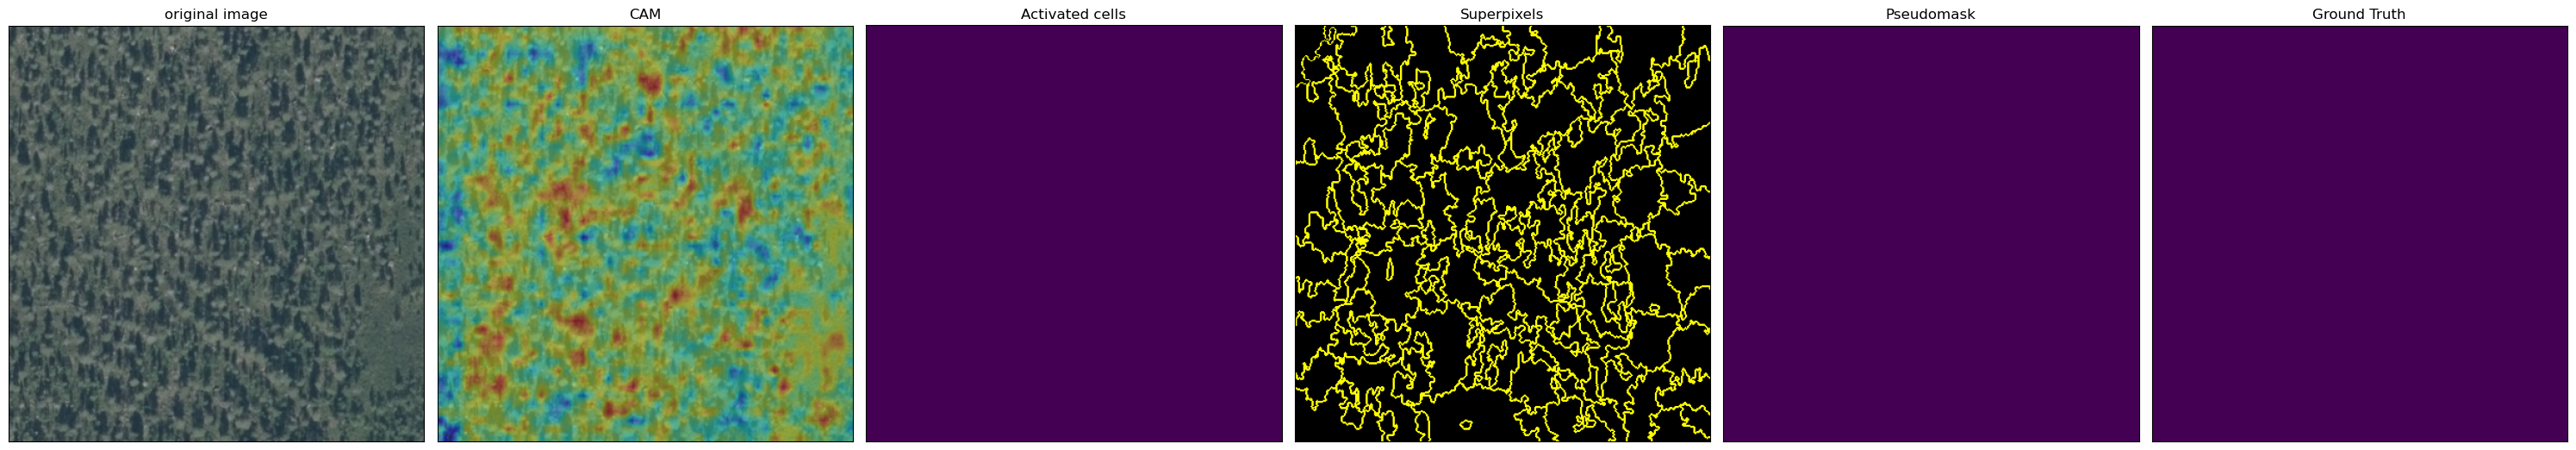

jaccard result = 0.0
accuracy result = 0.0


In [19]:
for im, lab, perc_label, gt_mask in test_loader:
    if perc_label == 0:
        pseudomask = pseudomask_generator.generate_mask(im, gt_mask, save_plot=True)
        break

# define metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
jaccard = MulticlassJaccardIndex(num_classes=2).to(device)
accuracy = Accuracy(task="multiclass", num_classes=2).to(device)

generated_mask = torch.Tensor(pseudomask).int().view(400,400).to(device)
groundtruth_mask = torch.Tensor(gt_mask).int().view(400,400).to(device)

print(f'jaccard result = {jaccard(generated_mask, groundtruth_mask)}')
print(f'accuracy result = {accuracy(generated_mask, groundtruth_mask)}')

#### playing around with pseudomask parameters 

In [ ]:
# Hardcode configs: 

artifact_path = 'nadjaflechner/VGG_CAMs/classification_model:v62'

testset_dir = '/Users/nadja/Documents/UU/Thesis/Data/FINALFINAL_200m_groundtruths'
depth_layer = 'hs'
normalize = True
finetune = False

test_set = TestSet(depth_layer, testset_dir, normalize)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

In [ ]:
cam_threshold_factor = 0.5
overlap_threshold = 0.5
snic_seeds = 100
snic_compactness = 10

pseudomask_generator = Pseudomasks(test_loader, cam_threshold_factor, overlap_threshold,
                                    snic_seeds, snic_compactness, finetuned = finetune)
pseudomask_generator.model_from_artifact(artifact_path)
